In [120]:
Recology_Litter.head()

,Date,agency_responsible
9390,2020-12-31,Parking Enforcement Dispatch Queue
9393,2020-12-31,Parking Enforcement Dispatch Queue
9396,2020-12-31,Parking Enforcement Dispatch Queue
9400,2020-12-31,Parking Enforcement Dispatch Queue
9404,2020-12-31,Parking Enforcement Dispatch Queue


In [121]:
Recology_Litter.agency_responsible = 1

In [122]:
Recology_Litter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153406 entries, 9390 to 1802548
Data columns (total 2 columns):
Date                  153406 non-null datetime64[ns]
agency_responsible    153406 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.5 MB


In [123]:
Recology_Litter.set_index('Date', inplace = True)

In [124]:
Recology_Litter_grouped = Recology_Litter.groupby(['Date'], as_index = False).resample('M').sum()

In [125]:
Recology_Litter_grouped.head()

,,agency_responsible
,Date,
0,2018-03-31,9
1,2018-03-31,7
2,2018-03-31,16
3,2018-04-30,6
4,2018-04-30,12


### Grouping by Month

In [126]:
Recology_Litter_grouped = pd.DataFrame(Recology_Litter_grouped)

In [127]:
Recology_Litter_grouped.head()

,,agency_responsible
,Date,
0,2018-03-31,9
1,2018-03-31,7
2,2018-03-31,16
3,2018-04-30,6
4,2018-04-30,12


In [128]:
Recology_Litter_grouped = Recology_Litter_grouped.groupby('Date').sum()

In [129]:
Recology_Litter_grouped.head()

,agency_responsible
Date,
2018-03-31,32
2018-04-30,2656
2018-05-31,4664
2018-06-30,3524
2018-07-31,3550


In [130]:
Recology_Litter_grouped.tail()

,agency_responsible
Date,
2020-08-31,5009
2020-09-30,4979
2020-10-31,5323
2020-11-30,4216
2020-12-31,3800


### ACF & PACF

 - The time series shows a lot of noise.
 - The ACF graph shows trends every 12 months reflecting seasonality. 
 - The PACF graph cuts off after one.

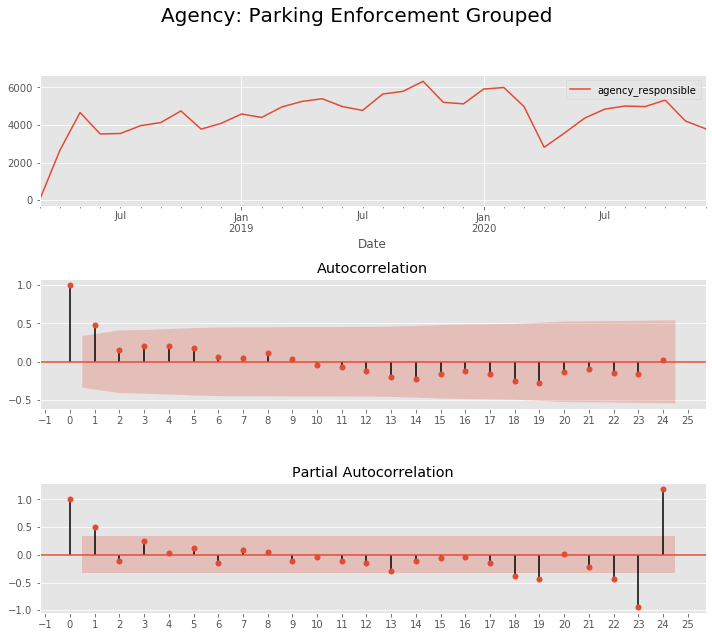

In [131]:
plot_acf_pacf(Recology_Litter_grouped, agency = 'Parking Enforcement Grouped')
plt.show()

### Decompose Time Series

The decomposed time series shows significant seasonal peaks in November and February. 
The trend of the time series peaks in Oct 2019 and decreases afterward.

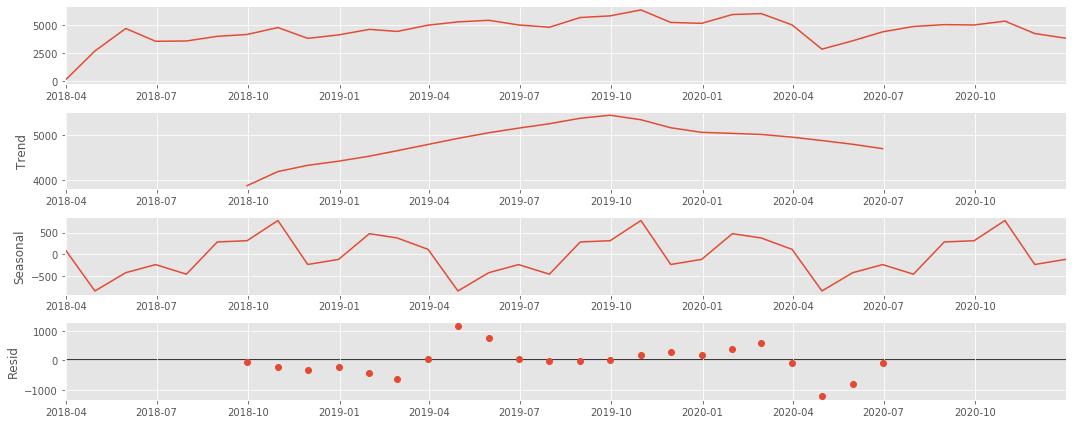

In [132]:
decompose_result = seasonal_decompose(Recology_Litter_grouped, model="additive")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

### Testing with the Dicky-Fuller Test

P-value shows stationarity without any adjustments. 

In [133]:
dftest = adfuller(Recology_Litter_grouped, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -3.5472013075165574
2. P-Value :  0.006854457091156849
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 32
5. Critical Values :
	 1% :  -3.653519805908203
	 5% :  -2.9572185644531253
	 10% :  -2.6175881640625


### SARIMAX Modeling: Parameter Selection

Since altering the time series only increased the p-value, the original time series will be used. 

In [134]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [135]:
# Run a grid with pdq and seasonal pdq parameters 
#calculated above and get the best (lowest) AIC value
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(Recology_Litter_grouped,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            #print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except:
            continue

### Fitting the Time Series Model - SARIMAX

Changing enforce_stationarity to True allows the plot diagnostics to be called. 

In [136]:
ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])

In [137]:
best_params = dict(ans_df.loc[ans_df['aic'].idxmin()])
best_params

{'pdq': (0, 0, 0), 'pdqs': (0, 2, 1, 12), 'aic': 4.0}

In [146]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(Recology_Litter_grouped, 
                                        order= best_params['pdq'], 
                                        seasonal_order=best_params['pdqs'], 
                                        enforce_stationarity=True, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:         agency_responsible   No. Observations:                   34
Model:             SARIMAX(0, 2, [1], 12)   Log Likelihood                 -93.718
Date:                    Mon, 18 Jan 2021   AIC                            191.436
Time:                            11:33:50   BIC                            192.042
Sample:                        03-31-2018   HQIC                           190.772
                             - 12-31-2020                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -1.0000      1.200     -0.833      0.405      -3.352       1.352
sigma2      5.899e+06   2.03e-07    2.9e+13      0.000     5.9e+06     5.9e+06
===================================================================================
Ljung-Box (Q):                        5.54   Jarque-Bera (JB):                 0.19
Prob(Q):                              0.79   Prob(JB):                         0.91
Heteroskedasticity (H):               0.76   Skew:                            -0.26
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

### Plot Diagnostics

- The standardized residual seems to show noise rather than a pattern.
- The histogram is normally distributed.
- The points on the QQ plot follow the line closely. 
- The points in the correlogram fall inside the box and do not indidcate a missed seasonality component. 

ValueError: operands could not be broadcast together with shapes (9,) (8,) (9,) 

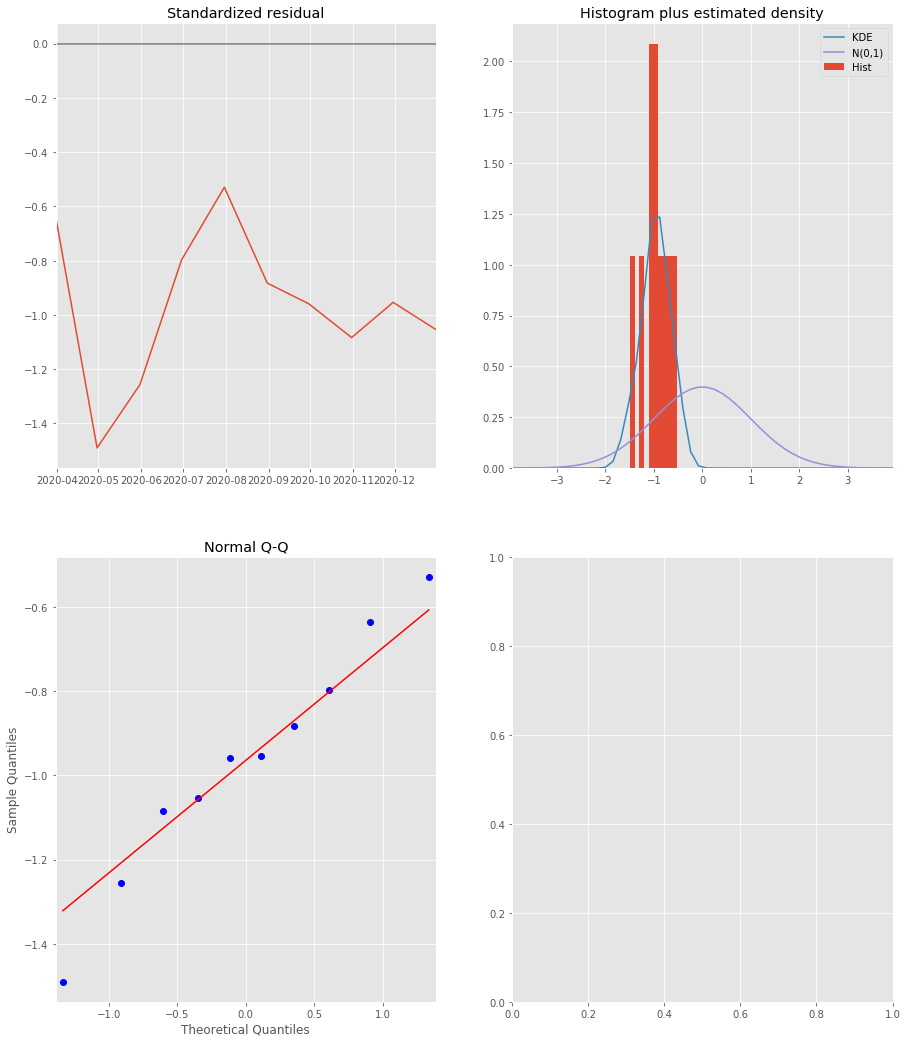

In [147]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

### Model Validation - One Step Ahead Forecasting:

The data can be split 80% and 20% by indicing at 10 steps before the end of the time series. This number will change as the time series expands.

In [155]:
Recology_Litter_grouped.head()

,agency_responsible
Date,
2018-03-31,32
2018-04-30,2656
2018-05-31,4664
2018-06-30,3524
2018-07-31,3550


In [148]:
full_set = Recology_Litter_grouped.size

In [149]:
eighty_percent = (full_set * .2).round(0)

In [150]:
threshold = full_set - eighty_percent

In [151]:
threshold

27.0

### Testing and Training Breakpoint

The time series will be sliced at 2020-03-31.

In [156]:
Recology_Litter_grouped[27:]

,agency_responsible
Date,
2020-06-30,4364
2020-07-31,4844
2020-08-31,5009
2020-09-30,4979
2020-10-31,5323
2020-11-30,4216
2020-12-31,3800


In [157]:
pred = output.get_prediction(start=pd.to_datetime('2020-03-31'), dynamic=False)
pred_conf = pred.conf_int()

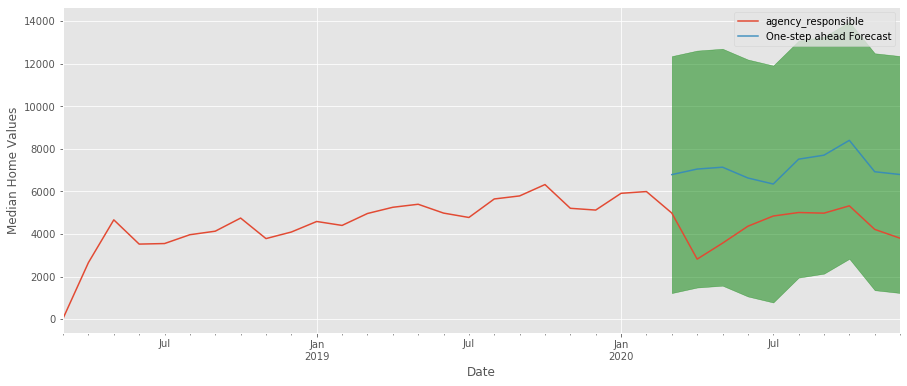

In [158]:

rcParams['figure.figsize'] = 15, 6

ax = Recology_Litter_grouped['2012':].plot(label='observed')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')
plt.legend()

plt.show()

### Accuracy Validation with RMSE (Root Mean Squared Error)

In [159]:
val_forecasted = pred.predicted_mean
val_truth = Recology_Litter_grouped.loc['2020-03-31':].agency_responsible

mse = np.sqrt(((val_forecasted - val_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2843.75


### Model Validation - Dynamic Forecasting

In [160]:
pred_dynamic = output.get_forecast(steps = 12)
pred_dynamic_conf = pred_dynamic.conf_int()


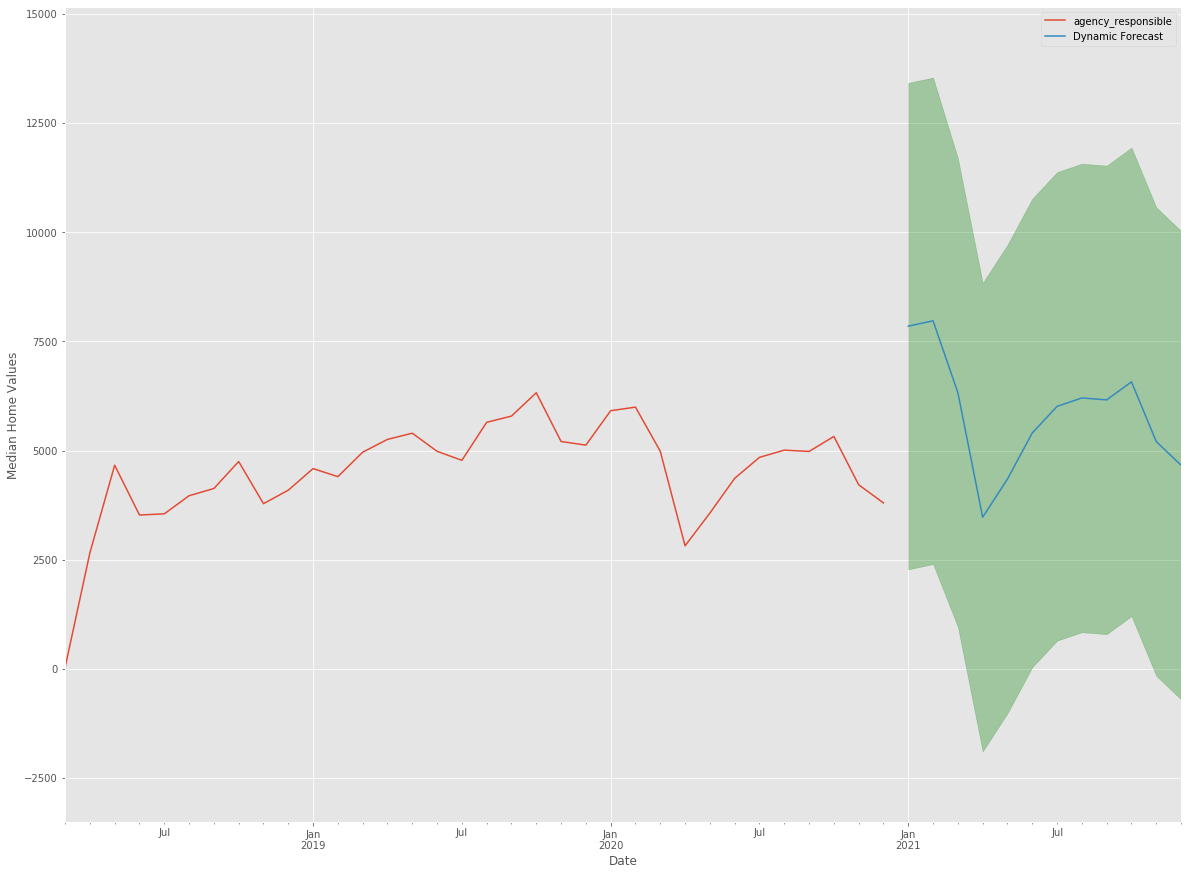

In [161]:
ax = Recology_Litter_grouped['2016':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-12-31'), val_forecasted.index[-1], alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Median Home Values')

plt.legend()
plt.show()


### Visualizing Confidence Interval

In [162]:
# Get forecast 24 steps ahead in future
prediction = output.get_forecast(steps=24)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

pred_conf['mean'] = prediction.predicted_mean

pred_conf.head()

,lower agency_responsible,upper agency_responsible,mean
2021-01-31,2278.394661,13417.871540,7848.133100
2021-02-28,2400.546597,13540.023477,7970.285037
2021-03-31,962.503370,11689.716320,6326.109845
2021-04-30,-1889.825576,8837.387374,3473.780899
2021-05-31,-1016.125323,9711.087627,4347.481152


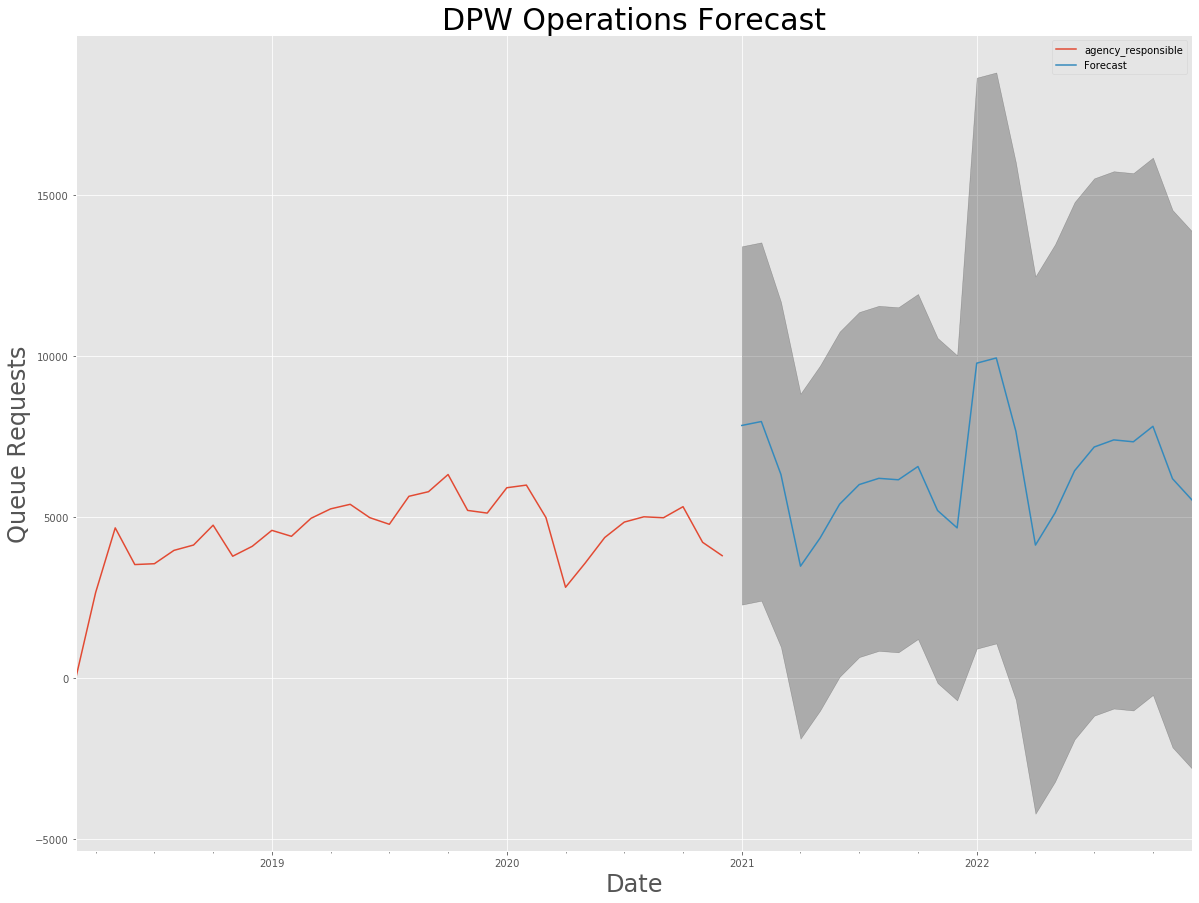

In [163]:
ax = Recology_Litter_grouped.plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date', fontdict={'fontsize' : 24})
ax.set_ylabel('Queue Requests', fontdict={'fontsize' : 24})
ax.set_title('Parking Enforcement Forecast', fontdict={'fontsize' : 30})

plt.legend()
plt.show()

### Parking Enforcement Conclusion

The increase from the beginning of the time period to the end is 

In [164]:
Difference = Recology_Litter_grouped.agency_responsible[-1] - Recology_Litter_grouped.agency_responsible[0]

In [165]:
Difference

3768

### Results Dataframe

In [172]:
results.head()

,index,call_increase
0,DPW Ops Queue,1
1,Recology_Abandoned,1
2,Parking Enforcement Dispatch Queue,1
3,DPT Abandoned Vehicles Work Queue,1
4,HSOC Queue,1


In [174]:
results.call_increase[2] = Difference
results.head()

,index,call_increase
0,DPW Ops Queue,3768
1,Recology_Abandoned,1
2,Parking Enforcement Dispatch Queue,3768
3,DPT Abandoned Vehicles Work Queue,1
4,HSOC Queue,1
